In [2]:
import numpy as np
import os 
import matplotlib.pyplot as plt

# 


# load the data stored in 1d_RDE_sim/1d_dataset_hard_dataset:
data_high_fidelity_sim = np.load('1d_RDE_sim/1d_dataset_hard_dataset.npy')
print(data_high_fidelity_sim.shape)

# load the sim from the Koch model:
data_koch_model = np.load('Koch_model/temperature_field.npy')
print(data_koch_model.shape)

(250, 100)
(200001, 100)


In [3]:
def plot_1d_dataset_as_heatmap(dataset1d, title = ""): 

    plt.figure(figsize=(10, 6))
    plt.imshow(dataset1d.T, aspect='auto', cmap='jet', extent=[0, dataset1d.shape[0], 0, dataset1d.shape[1]])
    plt.colorbar(label='Value')
    plt.xlabel('Time Index')
    plt.ylabel('X Index')
    plt.title(title)
    plt.show()
    

Plotting high-fidelity simulation dataset...


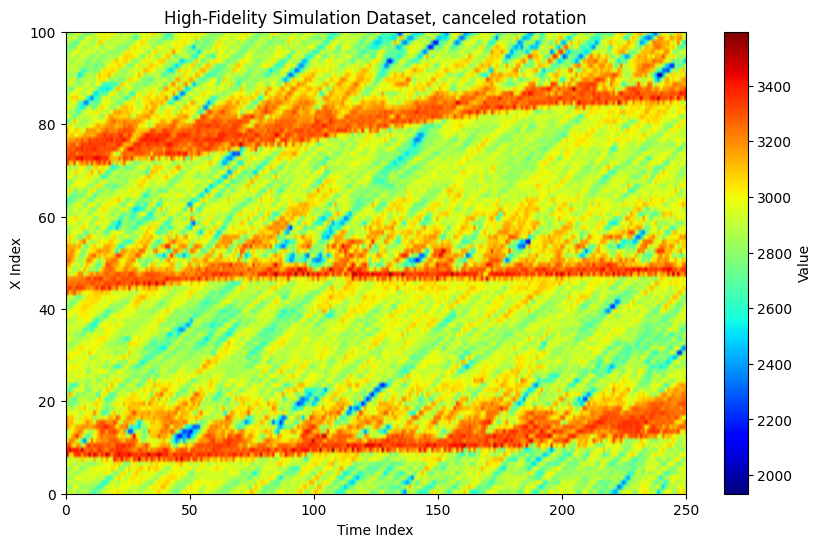

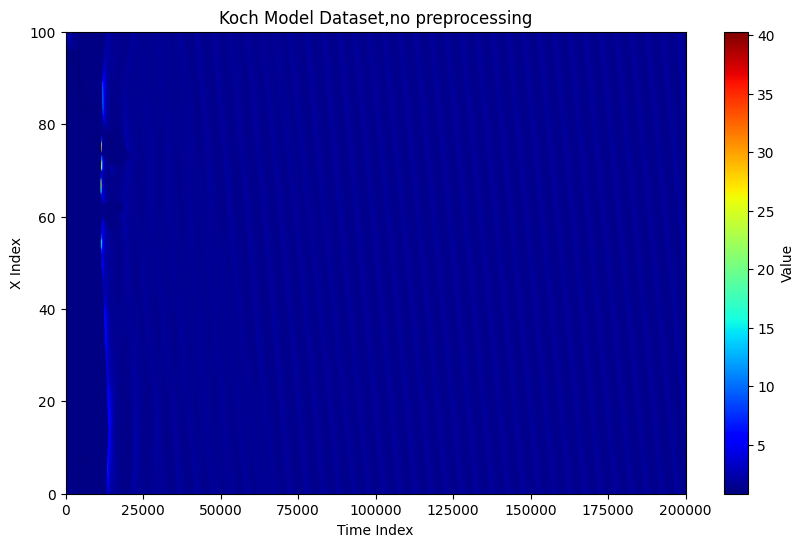

In [9]:
print("Plotting high-fidelity simulation dataset...")
plot_1d_dataset_as_heatmap(data_high_fidelity_sim, title="High-Fidelity Simulation Dataset, canceled rotation")
plot_1d_dataset_as_heatmap(data_koch_model, title="Koch Model Dataset,no preprocessing")

In [10]:
def straighten_data(data, shift_per_row):
    """
    Straighten x-direction rotation over time via row-wise circular *fractional* shifts.

    Args:
        data: array of shape (T, n)
        shift_per_row: scalar (pixels per timestep for every row)

    Returns:
        straightened: array of shape (T, n)
    """
    T, n = data.shape
    
    # FFT along the spatial dimension (axis 1)
    data_fft = np.fft.fft(data, axis=1)
    
    # Wavenumbers (frequencies)
    # fftfreq returns f = k/n corresponding to the frequencies
    freqs = np.fft.fftfreq(n)
    
    # Shifts for each row: shape (T, 1)
    # We assume the shift accumulates linearly with time index
    shifts = (np.arange(T) * shift_per_row).reshape(-1, 1)
    
    # Fourier shift theorem: f(x - d) <-> F(k) * exp(-2*pi*i * f * d)
    # We want to shift by 'shifts'.
    phase_shift = np.exp(-2j * np.pi * freqs[np.newaxis, :] * shifts)
    
    data_shifted_fft = data_fft * phase_shift
    
    data_shifted = np.fft.ifft(data_shifted_fft, axis=1)
    
    return np.real(data_shifted)

def preprocessing_Koch_model(dataset, nx_sim, T_sim):
    
    T, n = dataset.shape
    print(f"Koch model dataset shape: T={T}, n={n}")
    if T > T_sim:
        t_start = 100_000
        t_end   = 110_000
        dataset_cropped = dataset[t_start:t_end, :]
        
        print(f" Cropped Koch model dataset to shape: {dataset_cropped.shape}")
    else:
        dataset_cropped = dataset
        print(" No cropping needed for Koch model dataset.")
        
    T, n = dataset_cropped.shape
    if T > T_sim: 
        # we have to subsample in time
        factor = T // T_sim
        print(f"factor for time subsampling: {factor}")
        dataset_cropped = dataset_cropped[::factor, :]
    
    # cancel out the rotation
    SHIFT_PER_ROW =  -0.27  # pixels per timestep - adjust as needed
    print(f"Applying wave straightening with shift_per_row={SHIFT_PER_ROW}")
    print(" shape of load_X before straightening: ", dataset_cropped.shape)
    Koch_model_straightened = straighten_data(
        dataset_cropped, shift_per_row=SHIFT_PER_ROW
    )

    Koch_model_straightened_minmax = (Koch_model_straightened - np.min(Koch_model_straightened)) / (np.max(Koch_model_straightened) - np.min(Koch_model_straightened))
    return Koch_model_straightened_minmax

def prepropressing_high_fidelity_sim(dataset):
    # normalize to [0, 1]
    dataset_minmax = (dataset - np.min(dataset)) / (np.max(dataset) - np.min(dataset))
    return dataset_minmax

T_sim, nx_sim = data_high_fidelity_sim.shape
print(f" High-fidelity sim shape: nx={nx_sim}, T={T_sim}")
print(f"Koch_model shape before processing: {data_koch_model.shape}")
data_koch_model_processed = preprocessing_Koch_model(data_koch_model, nx_sim, T_sim)
data_high_fidelity_sim_processed = prepropressing_high_fidelity_sim(data_high_fidelity_sim)
print(f"Koch_model shape after processing: {data_koch_model_processed.shape}")

 High-fidelity sim shape: nx=100, T=250
Koch_model shape before processing: (200001, 100)
Koch model dataset shape: T=200001, n=100
 Cropped Koch model dataset to shape: (10000, 100)
factor for time subsampling: 40
Applying wave straightening with shift_per_row=-0.27
 shape of load_X before straightening:  (250, 100)
Koch_model shape after processing: (250, 100)


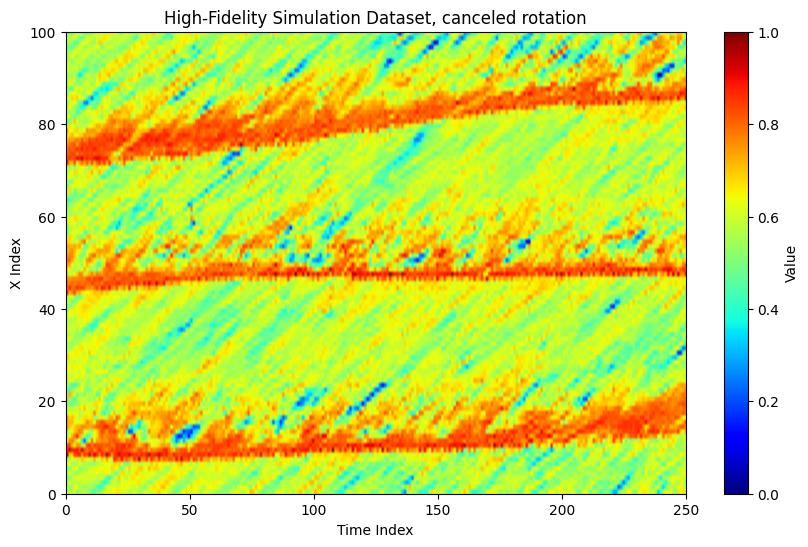

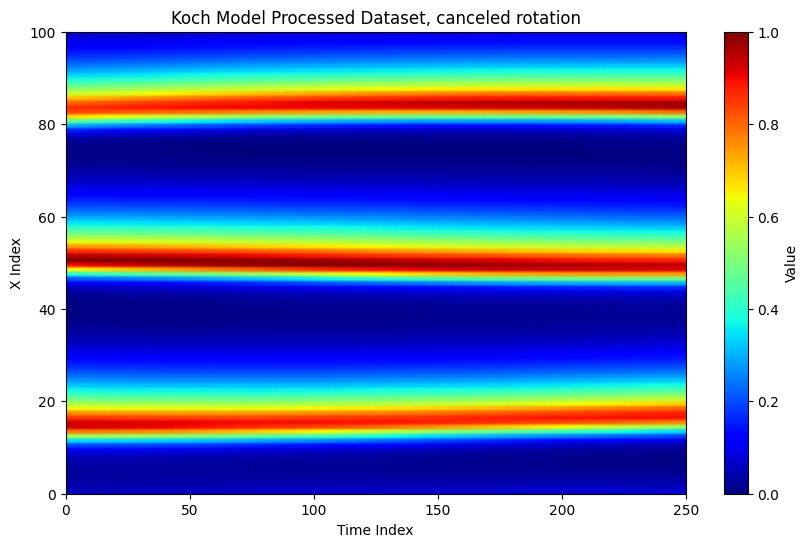

In [11]:
plot_1d_dataset_as_heatmap(data_high_fidelity_sim_processed, title="High-Fidelity Simulation Dataset, canceled rotation")
plot_1d_dataset_as_heatmap(data_koch_model_processed, title="Koch Model Processed Dataset, canceled rotation")